# Submitted By: M. Raza Khalid Saleemi
# Context
Every third bite of food relies on pollination by bees. At the same time, this past winter honeybee hive losses have exceeded 60% in some states. How can we address this issue? How can we better understand our bees? And most importantly, how can we save them before it's too late?

While many indications of hive strength and health are visible on the inside of the hive, frequent check-ups on the hive are time-consuming and disruptive to the bees' workflow and hive in general. By investigating the bees that leave the hive, we can gain a more complete understanding of the hive itself. For example, an unhealthy hive infected with varroa mites will have bees with deformed wings or mites on their backs. These characteristics can be observed without opening the hive. To protect against robber bees, we could track the ratio of pollen-carrying bees vs those without. A large influx of bees without pollen may be an indication of robber bees. This dataset aims to provide basic visual data to train machine learning models to classify bees in these categories, paving the way for more intelligent hive monitoring or beekeeping in general.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
%matplotlib inline

In [2]:
import cv2
import os

In [3]:
location_train = '../input/ds-14/train images/train images/'
train_images_name = os.listdir(location_train)

In [4]:
len(train_images_name)

4172

In [5]:
image_data = cv2.imread(location_train+train_images_name[0])

In [6]:
image_data.shape

(51, 48, 3)

In [7]:
train_data = pd.read_csv('../input/ds-14/train.csv')
train_data.head()

,file,date,location,health,subspecies
0,010_524.png,8/19/18,"Des Moines, IA, USA",healthy,Carniolan honey bee
1,030_388.png,8/17/18,"Alvin, TX, USA",ant problems,Italian honey bee
2,046_051.png,8/19/18,"Des Moines, IA, USA",healthy,Carniolan honey bee
3,021_210.png,8/8/18,"Saratoga, CA, USA",healthy,Italian honey bee
4,017_127.png,8/6/18,"Saratoga, CA, USA",healthy,Italian honey bee


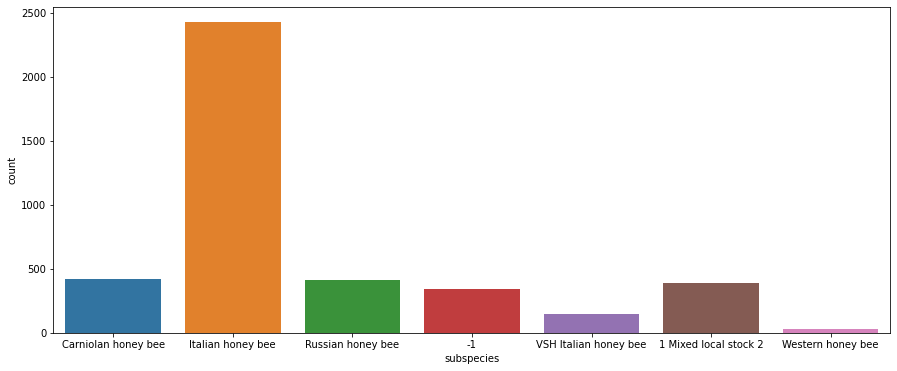

In [8]:
plt.figure(figsize= (15,6))
sns.countplot(train_data.subspecies)

In [12]:
H,W = [],[]
for i,filename in enumerate(train_data.file):
    oriimg = cv2.imread(location_train+filename)
    height, width, depth = oriimg.shape
    H.append(height)
    W.append(width)
print('maximum Image Height: ',max(H))
print('maximum Image Width: ',max(W))
print('Average Image Height: ',mean(H))
print('Average Image Width: ',mean(W))

maximum Image Height:  520
maximum Image Width:  392
Average Image Height:  71.52372962607862
Average Image Width:  73.9515819750719


In [14]:
H2= int(mean(H))
W2= int(mean(W))
oriimg = cv2.imread(location_train+train_data.file[0])
IMG = cv2.resize(oriimg,(W2,H2),interpolation=cv2.INTER_CUBIC).flatten()

for i,filename in enumerate(train_data.file):
    if i != 0:
        oriimg = cv2.imread(location_train+filename)
        newimg = cv2.resize(oriimg,(W2,H2),interpolation=cv2.INTER_CUBIC).flatten()
        IMG = np.vstack((IMG,newimg))
    

In [15]:
IMG.shape

(4172, 15549)

In [16]:
IMG.dtype

dtype('uint8')

In [17]:
Ytrain = train_data.subspecies

In [18]:
from sklearn.decomposition import PCA
pca = PCA(.95,random_state=42)

In [19]:
pca.fit(IMG)
PCA_of_IMG=pca.transform(IMG)
print(PCA_of_IMG.shape,Ytrain.shape)

(4172, 182) (4172,)


In [20]:
type(PCA_of_IMG)

numpy.ndarray

In [21]:
test_data = pd.read_csv('../input/ds-14/test.csv')
test_data.head()

,file,date,location,health
0,040_270.png,8/21/18,"Athens, GA, USA","few varrao, hive beetles"
1,016_004.png,8/20/18,"San Jose, CA, USA",healthy
2,005_112.png,7/7/18,"Saratoga, CA, USA",healthy
3,015_466.png,8/6/18,"Saratoga, CA, USA",healthy
4,015_777.png,8/6/18,"Saratoga, CA, USA",healthy


In [22]:
location_test = '../input/ds-14/test images/test images/'

In [23]:
oriimg = cv2.imread(location_test+test_data.file[0])
IMG_test = cv2.resize(oriimg,(W2,H2),interpolation=cv2.INTER_CUBIC).flatten()

for i,filename in enumerate(test_data.file):
    if i != 0:
        oriimg = cv2.imread(location_test+filename)
        newimg = cv2.resize(oriimg,(W2,H2),interpolation=cv2.INTER_CUBIC).flatten()
        IMG_test = np.vstack((IMG_test,newimg))

In [24]:
test_img=pca.transform(IMG_test)

# RandomForest Tuning

In [25]:
xtrain = PCA_of_IMG
ytrain = Ytrain
xtest = test_img

In [26]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=49, stop=51, num=3)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(24, 26, num=3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [ 2]

#criterion = ["gini", "entropy"]
criterion = [ "entropy"]
#max_features = ["auto", "sqrt", "log2"]

In [27]:
random_grid1 = {"n_estimators": n_estimators,
                "criterion": criterion,
                "max_depth": max_depth,
                #"max_features": max_features,
                "min_samples_split": min_samples_split}

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [29]:
clf_rf = RandomForestClassifier(n_estimators=500,random_state=100)
rf_random = RandomizedSearchCV(
    estimator=clf_rf, param_distributions=random_grid1, n_iter=5000, cv=5, verbose=1, random_state=100, n_jobs=4)


In [30]:
# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=5000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [31]:
clf_rf_rand = rf_random.best_estimator_

In [32]:

clf_rf_rand.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [33]:
pred_rf_rand = clf_rf_rand.predict(xtest)

# Submission


In [34]:
pred = pred_rf_rand

In [35]:
pred

array(['Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Russian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       '1 Mixed local stock 2', 'Italian honey bee', 'Italian honey bee',
       'Russian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Carniolan honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Russian honey bee', 'Italian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Russian honey bee',
       'Italian honey bee', 'Italian honey bee', 'Italian honey bee',
       '1 Mixed local stock 2', 'Italian honey bee',
       '1 Mixed local stock 2',

In [36]:
len(pred)

1000

In [37]:
test_data.file

0      040_270.png
1      016_004.png
2      005_112.png
3      015_466.png
4      015_777.png
          ...     
995    005_618.png
996    001_145.png
997    004_260.png
998    004_315.png
999    030_367.png
Name: file, Length: 1000, dtype: object

In [38]:
submission=pd.DataFrame({'file':test_data.file,'subspecies':pred})

submission.set_index(submission.columns[0],inplace= True)

# Write code here
submission.to_csv('Submission_RF_ver_1.csv')